# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data from https://www.openml.org/d/554 or from default local location `~/scikit_learn_data/...`
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape:', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape: (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

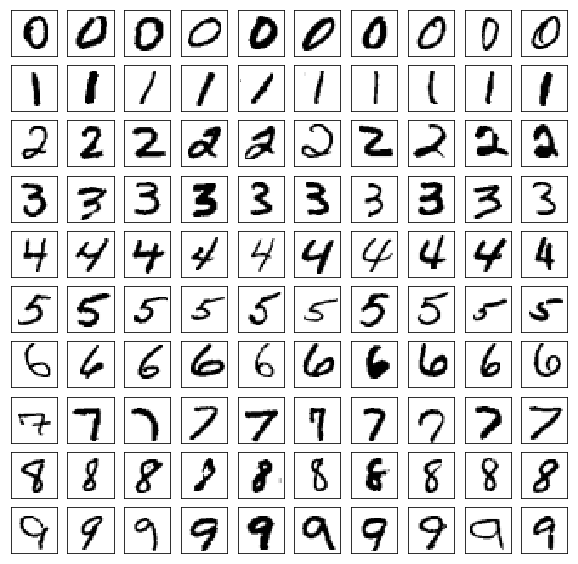

In [3]:
def P1(num_examples=10):

### STUDENT START ###

    plt.figure(figsize=(num_examples, 10)) # Set the plot size 
    pic_length = int(mini_train_data.shape[1] ** (1/2.0)) # calculate the number of pixel per side for each digit visualization
    
    #plot ten examples of a digit from 0 to 9
    plot_index = 0
    for digit in np.unique(mini_train_labels):
        for i in range(num_examples):        
            ax = plt.subplot(10, num_examples, plot_index+1) 
            plt.setp(ax, xticks=(), yticks=()) # Remove tick marks
            plt.imshow(mini_train_data[np.where(mini_train_labels==digit)][i].reshape(pic_length,pic_length), cmap='binary')
            
            plot_index += 1

### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
def P2(k_values):

### STUDENT START ###

    # Run KNN for each of the k values passed in and report on accuracy
    
    for k in k_values:

        KNN = KNeighborsClassifier(n_neighbors=k)
        KNN.fit(mini_train_data, mini_train_labels)

        predictions = KNN.predict(dev_data)
        
        if k == 1: k1_predictions = predictions ## memorize k=1 predictions for the classification_report() later
        
        correct = 0
        num_example = 0

        for predict, label in zip(predictions, dev_labels):
            if predict == label:
                correct += 1
            num_example +=1

        accuracy = round(correct/num_example,3) # calculate accuracy
        
        # print results
        print('K =', k)
        print('Total:', num_example, ', Correct:', correct, ', Accuracy:', accuracy)
        print('-'*50)
    
    
    ### Report with classification_report, show precision, recall, and F1 for each label
    
    print('\nDigit Classification Reprot for K=1:\n', classification_report(dev_labels, k1_predictions))
    
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

K = 1
Total: 1000 , Correct: 884 , Accuracy: 0.884
--------------------------------------------------
K = 3
Total: 1000 , Correct: 876 , Accuracy: 0.876
--------------------------------------------------
K = 5
Total: 1000 , Correct: 882 , Accuracy: 0.882
--------------------------------------------------
K = 7
Total: 1000 , Correct: 877 , Accuracy: 0.877
--------------------------------------------------
K = 9
Total: 1000 , Correct: 875 , Accuracy: 0.875
--------------------------------------------------

Digit Classification Reprot for K=1:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7      

ANSWER:

In the classification report, digit, 8 and 9 seemed to be the most difficult digits for k=1. Eight has the lowest recall and nine has the lowest precision. Yet 8 has the lowest f1-score which is the metric that takes the harmonic mean of precision and recall. Therefore, overall speaking, the model seems to have the most difficult time correctly classifying 8.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [5]:
def P3(train_sizes, accuracies):

### STUDENT START ###
    for train_size in train_sizes:
        
        KNN = KNeighborsClassifier(n_neighbors=1)
        KNN.fit(train_data[:train_size], train_labels[:train_size])
        
        time_start = time.time() # get the time when prediction starts
        
        predictions = KNN.predict(dev_data)
        
        time_end = time.time() # get the time when prediction ends
        
        correct = 0
        num_example = 0

        for predict, label in zip(predictions, dev_labels):
            if predict == label:
                correct += 1
            num_example +=1

        accuracy = round(correct/num_example,3)
        
        accuracies.append(accuracy)
        
        print('Training Size =', train_size)
        print('Total:', num_example, ', Correct:', correct, ', Accuracy:', accuracy)
        print('Prediction time:', round(time_end-time_start,3), 'seconds')
        print('-'*50)

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

Training Size = 100
Total: 1000 , Correct: 702 , Accuracy: 0.702
Prediction time: 0.118 seconds
--------------------------------------------------
Training Size = 200
Total: 1000 , Correct: 791 , Accuracy: 0.791
Prediction time: 0.234 seconds
--------------------------------------------------
Training Size = 400
Total: 1000 , Correct: 811 , Accuracy: 0.811
Prediction time: 0.462 seconds
--------------------------------------------------
Training Size = 800
Total: 1000 , Correct: 866 , Accuracy: 0.866
Prediction time: 0.997 seconds
--------------------------------------------------
Training Size = 1600
Total: 1000 , Correct: 905 , Accuracy: 0.905
Prediction time: 1.975 seconds
--------------------------------------------------
Training Size = 3200
Total: 1000 , Correct: 927 , Accuracy: 0.927
Prediction time: 3.949 seconds
--------------------------------------------------
Training Size = 6400
Total: 1000 , Correct: 939 , Accuracy: 0.939
Prediction time: 8.087 seconds
-------------------

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [6]:
#set up the arrays for linear regression

train_sizes_array = np.asarray(train_sizes)[:, np.newaxis] # ndarray of train_sizes
test_array = np.asarray([60000])[:, np.newaxis]  # ndarray of just the size of 60000
train_test_array = np.asarray(train_sizes+[60000])[:, np.newaxis] # ndarray of train_size plus the size, 60000

linear_regression = LinearRegression()

In [7]:
def P4():

### STUDENT START ###

    # fit train_sizes and accuracy with linear regression without any transformation
    linear_regression.fit(train_sizes_array, accuracies)
    print('The predicted accuracy of training size, 60000 is:', linear_regression.predict(test_array))

### STUDENT END ###

P4()

The predicted accuracy of training size, 60000 is: [1.24469234]


ANSWER:

The linear regression model overestimated the accuracy. As the figure 1 below indicated, the relationship between sample sizes and accuracy is actually not linear. As we increase the sample sizes, though we are getting better accuracy, there is actually diminishing return. Therefore, when we tried to predict the accuracy for training set size of 60000 by extrapolation, we would significantly overestimated.

Text(0.5, 1.0, 'figure 1')

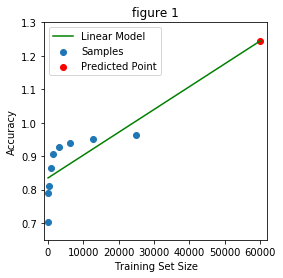

In [8]:
linear_regression.fit(train_sizes_array, accuracies)
plt.figure(figsize=(4, 4))

plt.plot(train_test_array, linear_regression.predict(train_test_array), c='g', label="Linear Model")
plt.scatter(train_sizes, accuracies, label="Samples")
plt.scatter(test_array, linear_regression.predict(test_array), c='r', label="Predicted Point")

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.xlim((-1000, 62000))
plt.ylim((0.65, 1.3))
plt.legend(loc="best")
plt.title('figure 1')

To make our prediction more reasonable, we need to apply transformation on the variables so they have a better linear relationship before fitting them to a linear regression model. The plot of the samples' accuracy over training set size seems like a logarithmic relationship, so we will log-transform the training set size. However, since the accuracy needs to be no greater than one, we will apply the logistic function on the log-transformed training set sizes. The definiton of the logistic function used here is $logistic(x) = \frac{1}{1+e^{-x}}$

Draw $Accuracy\ over\ logistic(log_{10}(train\_sizes))$

In [9]:
# define a class of the transformation used

class transform:
    def __init__(self):
        pass
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return self.sigmoid(np.log10(X))


Text(0.5, 1.0, 'Accuracy over Transformed train_sizes')

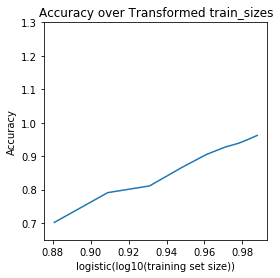

In [11]:
trans = transform()

plt.figure(figsize=(4, 4))
plt.plot(trans.transform(train_sizes_array), accuracies)

plt.xlabel("logistic(log10(training set size))")
plt.ylabel("Accuracy")
plt.ylim((0.65, 1.3))
plt.title('Accuracy over Transformed train_sizes')

It seems like the transformation works and the relationship is pretty linear, so we apply linear regression and extrapolate the performance again.

The predicted accuracy of training size, 60000 is: [0.97236404]


Text(0.5, 1.0, 'figure 2')

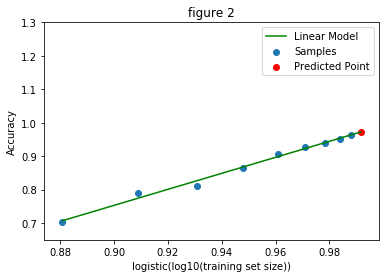

In [12]:
# build a pipeline that transforms the data and then applies linear regression
pipeline = Pipeline([("transform", trans),
                     ("linear_regression", linear_regression)])
# fit the data
pipeline.fit(train_sizes_array, accuracies)

# predict the accuracy for training size, 60000
print('The predicted accuracy of training size, 60000 is:', pipeline.predict(test_array))

# plot the relationship between transformed training sizes and accuracy

plt.plot(trans.transform(train_test_array),pipeline.predict(train_test_array), c='g', label="Linear Model")
plt.scatter(trans.transform(train_sizes_array), accuracies, label="Samples")
plt.scatter(trans.transform(test_array), pipeline.predict(test_array), c='r', label="Predicted Point")

plt.xlabel("logistic(log10(training set size))")
plt.ylabel("Accuracy")
plt.ylim((0.65, 1.3))
plt.legend(loc="best")
plt.title('figure 2')

We can see in figure 2 and the prediction result. We now have a much more reasonable model for the prediction. The result of 0.972 seems reasonable given the trend we see in our sample.

(5) Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

The Confusion Matrix is:
--------------------------------------------------
[[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]]
-------------------------------------------------- 

The most confused pair(s) have a misclassification rate of 12.0%
They are:
	4 is most frequently misclassified as 9
-------------------------------------------------- 

Five Examples of Incorrect Classifications for Each Pair:


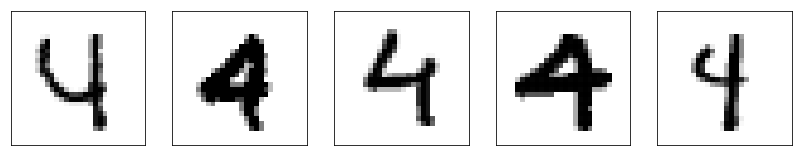

In [23]:
def P5():

### STUDENT START ###

    # calculate the count of each label in the dev data set

    counts = {}
    for label in dev_labels:
        if label not in counts.keys():
            counts[label] = 1
        else:
            counts[label] += 1

    # train the model of 1-nearest neighbor with mini_train_data
    KNN = KNeighborsClassifier(n_neighbors=1)
    KNN.fit(mini_train_data, mini_train_labels)

    # predict the data in dev
    k1_predictions = KNN.predict(dev_data)

    # generate the confusion matrix
    con_matrix = confusion_matrix(dev_labels, k1_predictions, labels = np.sort(np.unique(dev_labels)))

    
    # scan through the confusion matrix to find the most confused pair

    max_error_rate = 0.0
    confused_pairs = []


    for i in range(10):
        for j in range(10):
            
            if i == j: continue #skip the true positives

            # Find the most confusing digit that is most frequently identified as another digit (with the highest error rate)
            error_rate = con_matrix[i][j]/counts[str(i)]

            if error_rate > max_error_rate: # update confused_pairs if exceeding the current max error rate
                max_error_rate = error_rate
                confused_pairs = [(i,j)]
            elif error_rate == max_error_rate: # append to confused_pairs if tied with the current max error rate
                confused_pairs.append((i,j))

    print('The Confusion Matrix is:')  
    print('-'*50)
    print(con_matrix)
    print('-'*50, '\n')

    print('The most confused pair(s) have a misclassification rate of %3.1f%%' %(max_error_rate*100))
    print('They are:')
    # print all the pair(s) that has the same error rate
    for pair in confused_pairs:
        print('\t%d is most frequently misclassified as %d' %pair)
    
    print('-'*50, '\n')


    # print the five examples of incorrect classifications. Will have multiple rows if there are more than one pair

    print('Five Examples of Incorrect Classifications for Each Pair:')
    row_num = len(confused_pairs)
    plt.figure(figsize=(14, row_num*4))
    pic_length = int(mini_train_data.shape[1] ** (1/2.0))

    index = 0

    for pair in confused_pairs:
        i = 0
        for j in range(len(dev_labels)):
            if dev_labels[j] == str(pair[0]) and k1_predictions[j] == str(pair[1]):
                ax = plt.subplot(row_num, 5, index+1) 
                plt.setp(ax, xticks=(), yticks=()) # Remove tick marks
                plt.imshow(dev_data[j].reshape(pic_length,pic_length), cmap='binary')
                i+=1
                index+=1
            if i >= 5:
                break

### STUDENT END ###

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

The formula for the Gaussian blur filter calculation is:

$G(x,y) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$, where x and y is the location of the pixel relative to the central pixel

In [41]:
# The result of the precomputed Gaussian filter with sigma = 1, for a filter of 3X3
g_kernel = np.array([[0.077847,0.123317,0.077847],[0.123317,0.195346,0.123317],[0.077847,0.123317,0.077847]])

In [42]:
# define a class to apply Gaussian filter on pictures

class Guassian_Blur:
    
    def __init__(self, kernel):
        self.kernel = kernel
    
    def blur(self, pics):
        '''The blur function takes in a set of samples and return the blurred version'''
        
        blurred_collection = np.empty((0, pics.shape[1]))
        pic_length = int(pics.shape[1] ** (1/2.0))
        
        for pic in pics:
            blurred_pic = self._blur_item(pic.reshape(pic_length, pic_length), pic_length)
            blurred_collection = np.vstack((blurred_collection, blurred_pic))
                
        return blurred_collection
    
    def _blur_item(self, item, length):
        
        
        blurred = np.zeros((length,length))
        
        # blur the picture by superimposing the filtered results of each pixel on one another
        for i in range(length):
            for j in range(length):
                
                if item[i][j] == 0: continue # skip the pixel with value as zero to speed things up
                
                cal_kernel = self.kernel * item[i][j]
                temp = np.zeros((length,length))
                
                # make sure the filter is place in the right location on the picture for superimposition
                for k in range(-1,2):
                    if i + k < 0: continue
                    elif i + k > length-1: continue
                    for l in range(-1,2):
                        if j + l < 0: continue
                        elif j + l > length-1: continue
                        temp[i+k][j+l] = cal_kernel[k+1][l+1]

                blurred += temp

        return blurred.flatten()        

In [43]:
# blur the pictures in dev and training set (only to 3200 examples)

g_blur = Guassian_Blur(g_kernel)

blurred_train_data = g_blur.blur(train_data[:3200])
blurred_dev_data = g_blur.blur(dev_data)

# put the data combinations into two lists so we can iterate through the combinations
train_collection = [train_data[:3200], blurred_train_data]
dev_collection = [dev_data, blurred_dev_data]

In [46]:
def P6():

### STUDENT START ###
    for train_size in train_sizes:
        print('Training Size = %d:' %train_size)
        
        index = 0
        
        for dev in dev_collection:
            for train in train_collection:
                
                KNN = KNeighborsClassifier(n_neighbors=1)
                KNN.fit(train[:train_size], train_labels[:train_size])

                predictions = KNN.predict(dev)

                correct = 0
                num_example = 0

                for predict, label in zip(predictions, dev_labels):
                    if predict == label:
                        correct += 1
                    num_example +=1

                accuracy = round(correct/num_example,3)
                
                if index == 0: desc = 'No Blur'
                elif index == 1: desc = 'Only blur train_data'
                elif index == 2: desc = 'Only blur dev_data'
                elif index == 3: desc = 'Blur Both'
                
                print('Case: %-20s' %desc, '|', 'Accuracy:', accuracy)
                
                index += 1
        
        print('-'*50, '\n')

### STUDENT END ###

P6()

Training Size = 100:
Case: No Blur              | Accuracy: 0.702
Case: Only blur train_data | Accuracy: 0.721
Case: Only blur dev_data   | Accuracy: 0.691
Case: Blur Both            | Accuracy: 0.728
-------------------------------------------------- 

Training Size = 200:
Case: No Blur              | Accuracy: 0.791
Case: Only blur train_data | Accuracy: 0.814
Case: Only blur dev_data   | Accuracy: 0.782
Case: Blur Both            | Accuracy: 0.814
-------------------------------------------------- 

Training Size = 400:
Case: No Blur              | Accuracy: 0.811
Case: Only blur train_data | Accuracy: 0.841
Case: Only blur dev_data   | Accuracy: 0.816
Case: Blur Both            | Accuracy: 0.846
-------------------------------------------------- 

Training Size = 800:
Case: No Blur              | Accuracy: 0.866
Case: Only blur train_data | Accuracy: 0.896
Case: Only blur dev_data   | Accuracy: 0.865
Case: Blur Both            | Accuracy: 0.893
-------------------------------------

ANSWER:

Compare results of the combinations and also the results without any blurring, it there is some gain in accuracy when the training set is blurred. Because with blurring of the training set, we are going to be less biased by the local information in training data, therefore, the algorithm generalizes better with data outside outside of the training set.

Blurring of the dev data doesn't have any obvious improvement in our accuracy because to the algorithm, regardless if it's blurred or not it's just new data that it has never seen before, and blurring might even make the dev data lose some important traits useful for classification.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

Preprocess the data for learning:

In [47]:
def binarize_data(data):
    '''function to binarize data'''
    bin_data = np.zeros(data.shape)

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i][j] >= 0.5:
                bin_data[i][j] = 1
            else:
                bin_data[i][j] = 0
                
    return bin_data

In [48]:
# binarize both train and dev data
bin_mini_train_data = binarize_data(mini_train_data)
bin_dev_data = binarize_data(dev_data)

In [49]:
def bukect_data(data):
    '''function to put data in three buckets'''
    bucketed_data = np.zeros(data.shape)

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i][j] >= 0.66:
                bucketed_data[i][j] = 2
            elif data[i][j] >= 0.33:
                bucketed_data[i][j] = 1
            else:
                bucketed_data[i][j] = 0
    
    return bucketed_data

In [50]:
# bucket both train and dev data in three groups
tri_mini_train_data = bukect_data(mini_train_data)
tri_dev_data = bukect_data(dev_data)

In [51]:
def P7():

### STUDENT START ###
    bnb = BernoulliNB(alpha = 0)
    bnb.fit(bin_mini_train_data, mini_train_labels)

    mnb = MultinomialNB(alpha = 0)
    mnb.fit(tri_mini_train_data, mini_train_labels)

    print('Accuracy of BernoulliNB:', bnb.score(bin_dev_data, dev_labels))
    print('Accuracy of MultinomialNB:', mnb.score(tri_dev_data, dev_labels))

### STUDENT END ###

P7()

Accuracy of BernoulliNB: 0.815
Accuracy of MultinomialNB: 0.806


C:\Users\erik.hou\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\erik.hou\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


ANSWER:

Bucketing the data in three groups didn't improve accuracy because with limited training data, bucketing in three groups might make local traits more weighted in the decision making of the algorithm. Furthermore, since wee didn't apply any smoothing, and with only 1000 examples in our mini training set, increasing number of categories in a feature, some $P(feature=category|label)$ might be zero just simply because it doesn't exists in our training data. The extra binning makes the model more prone to overftting and the accuracy dropped because of it.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

C:\Users\erik.hou\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\erik.hou\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\erik.hou\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\erik.hou\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\erik.hou\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha

The best alpha is: 0.001
--------------------------------------------------
alpha = 0.0, Accuracy =  0.83
alpha = 0.001, Accuracy =  0.841


C:\Users\erik.hou\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


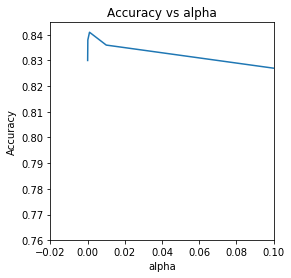

In [54]:
def P8(alphas):

### STUDENT START ###
    # create an instance of BernoulliNB()
    bnb = BernoulliNB()
    
    # create GridSearchCV on the BernoulliNB model with different alphas with cross-validation set to 5
    grid_search = GridSearchCV(bnb, alphas, cv=5)
    
    # fit the data
    grid_search.fit(bin_mini_train_data, mini_train_labels)
    
    # report the results 
    print('The best alpha is:', grid_search.best_params_['alpha'])
    print('-'*50)
    
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        if params['alpha'] == 0 or params['alpha'] == grid_search.best_params_['alpha']:
            print('alpha =', '%s,' %params['alpha'], 'Accuracy = ', mean_score)
    
    # plot a graph of accuracy over alpha for answer below
    
    plt.figure(figsize=(4, 4))
    plt.plot(alphas['alpha'], cvres["mean_test_score"])

    plt.xlabel("alpha")
    plt.ylabel("Accuracy")
    plt.xlim((-0.02, 0.1))
    plt.title('Accuracy vs alpha')


### STUDENT END ###
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

ANSWER:

From the results above, we found the best alpha that maximized the accuracy to be 0.001. It is to be expected that models with alpha > 0 will have better accuracy than models with alpha = 0. When there's no smoothing at all, some $P(feature=category|label)$ might be zero just simply because the data point doesn't exists in our training data. Smoothing let the model relax a bit and not overly rely on the local properties of our training data. Therefore, with alpha > 0, our model generalizes better to dev data and results in improved accuracy.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [57]:
def P9():

### STUDENT END ###
    
    # create an instance of GaussianNB, fit the data and report accuracy on dev data
    gnb = GaussianNB()
    gnb.fit(mini_train_data, mini_train_labels)
    print('Original accuracy:', gnb.score(dev_data, dev_labels))
    print('-'*50)
    
    # sample some mean and SD of our parameter distribution and print them

    np.random.seed(0)
    index = np.random.randint(0, high = 783, size=30)

    print('Thirty randomly sampled feature mean for 4:')
    print(gnb.theta_[4,index])
    print('-'*50)
    print('The thirty corresponding feature SD for 4:')
    print(gnb.sigma_[4,index])
    print('-'*50, '\n')
    
    # generate some noise, add it to our model for training and report accuracy on dev data
    
    np.random.seed(0)
    noise = np.random.normal(scale = 0.1, size = mini_train_data.shape)
    gnb.fit(mini_train_data + noise, mini_train_labels)
    gnb.score(dev_data, dev_labels)
    print('Accuracy of model including noise:', gnb.score(dev_data, dev_labels))
    
    
### STUDENT END ###

gnb = P9()

Original accuracy: 0.593
--------------------------------------------------
Thirty randomly sampled feature mean for 4:
[0.13139276 0.         0.29436022 0.05178896 0.         0.
 0.0239337  0.         0.         0.00501314 0.         0.14424904
 0.         0.04127754 0.22567212 0.02797655 0.12569234 0.
 0.41641399 0.14061047 0.         0.02999798 0.22567212 0.
 0.01960784 0.00097029 0.         0.         0.         0.00804528]
--------------------------------------------------
The thirty corresponding feature SD for 4:
[8.66943719e-02 2.01433307e-10 1.76518568e-01 3.96643444e-02
 2.01433307e-10 2.01433307e-10 1.43162971e-02 2.01433307e-10
 2.01433307e-10 2.41263048e-03 2.01433307e-10 1.03647440e-01
 2.01433307e-10 3.07510889e-02 1.36168729e-01 2.10258955e-02
 7.34170828e-02 2.01433307e-10 1.85278566e-01 9.78944626e-02
 2.01433307e-10 1.64758334e-02 1.36168729e-01 2.01433307e-10
 1.77977544e-02 9.03796916e-05 2.01433307e-10 2.01433307e-10
 2.01433307e-10 3.19508255e-03]
---------------

ANSWER:

The original Gaussian Naive Bayes model had really low accuracy compared to the Bernoulli one, only 0.593. After examining the feature mean and standard deviation, the observation is that they mostly have really narrow distribution, i.e., very small SD, few of the higher ones are around 0.2 with many of them having values lower than $10^{-5}$. In addition, many white spaces have the mean as 0 and SD as $10^{-10}$.

This is a sign of overfitting and will make the model generalize poorly. For example, imagine an example with a black pixel(noise) in the space that is with the distribution of mean as 0 and SD as $10^{-10}$, this dot will have a great impact on the probability of our classification even though it's an unimportant feature. These kind of instances significantly obscure the real characteristics our model is trying to use for classification almost in a random fashion.

Therefore, after some small noise are added into the the fitting stage (a similar concept as blurring), the probability distributions of the features are not as extremely concentrated. This significantly increase the model performance and dealt with the overfitting issue.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

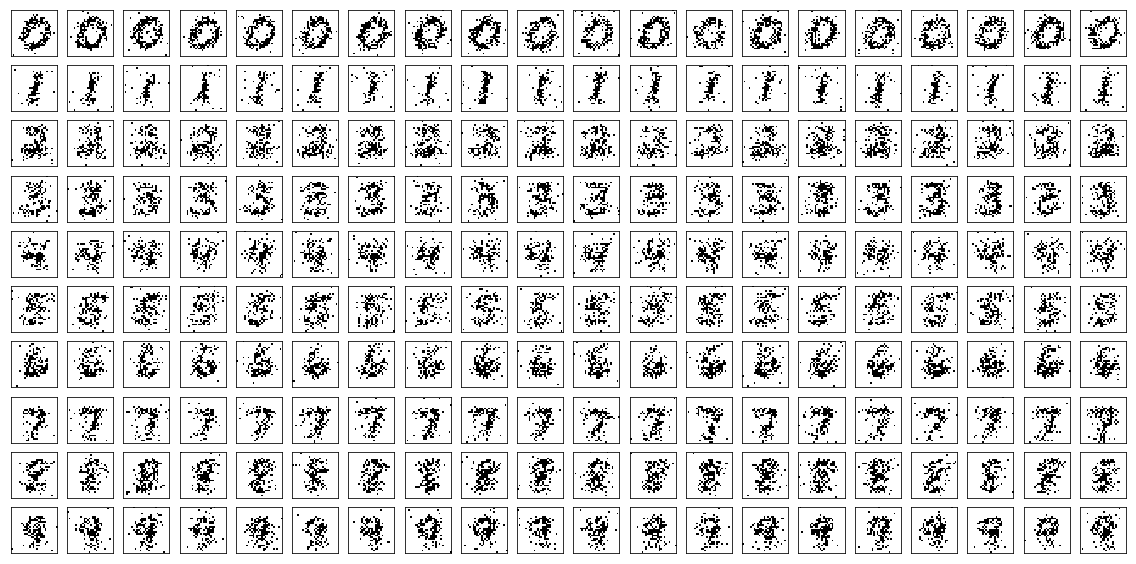

In [144]:
def P10(num_examples):

### STUDENT START ###
    
    
    num_pixels = bin_mini_train_data.shape[1]
    
    # create and fit the model
    bnb = BernoulliNB()
    bnb.fit(bin_mini_train_data, mini_train_labels)
    
    # use seeding to make sure we get the same result everytime the code is run
    np.random.seed(0)
    
    # initialize generated data and labels
    gen_data = np.empty((0,num_pixels))
    gen_labels = np.empty((0,0))
    
    # generate data and labels
    for i in range(10):
        # append new labels to the generated labels
        gen_labels = np.append(gen_labels, np.repeat([i], num_examples))
        
        # get the conditional probability of the features
        probs = np.exp(bnb.feature_log_prob_[i,])
        
        # genearte examples in specified numbers and accumulate them
        digit_examples = (np.random.rand(num_examples,num_pixels) < probs).astype(int)
        gen_data = np.vstack((gen_data, digit_examples))

    
    # visualize the genearted digits

    plt.figure(figsize=(num_examples, 10)) # Set the plot size 
    pic_length = int(num_pixels ** (1/2.0)) # calculate the number of pixel per side for the visualization

    plot_index = 0
    for digit in np.unique(gen_labels):
        for i in range(num_examples):        
            ax = plt.subplot(10, num_examples, plot_index+1) 
            plt.setp(ax, xticks=(), yticks=()) # Remove tick marks
            plt.imshow(gen_data[np.where(gen_labels==digit)][i].reshape(pic_length,pic_length), cmap='binary')

            plot_index += 1


### STUDENT END ###

P10(20)

ANSWER:

The generated digits take the general shapes of the real digits they are representing. However, for some digits, especially 4 the details are very blurry with lots of noise.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [62]:
# write a function to bucket a prediction based on confidence
def predict_bucket(prob, buckets):
    for i in range(len(buckets)):
        if prob <= buckets[i]: return i

In [63]:
def P11(buckets, correct, total):
    
### STUDENT START ###
    # create and train the model, using alpha = 0.01
    bnb = BernoulliNB(alpha = 0.01)
    bnb.fit(bin_mini_train_data, mini_train_labels)

    # get all the probabilities associated with each dev_data point
    all_probs = bnb.predict_proba(bin_dev_data)
    # get the predicted digits in int that can help with indexing the max probability
    predictions = bnb.predict(bin_dev_data).astype(int)
    
    for i in range(len(predictions)):
        # get the max posterior for a prediction
        max_prob = all_probs[i][predictions[i]]
        
        # get the bucket based on the posterior
        bucket = predict_bucket(max_prob, buckets)
        
        # update total and correct 
        total[bucket] += 1
        if predictions[i] == int(dev_labels[i]):
            correct[bucket] += 1
                
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]

correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
   accuracy = 0.0
   if (total[i] > 0): accuracy = correct[i] / total[i]
   print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  37    accuracy = 0.405
p(pred) <= 0.9990000000000    total =  90    accuracy = 0.411
p(pred) <= 0.9999900000000    total =  79    accuracy = 0.570
p(pred) <= 0.9999999000000    total =  64    accuracy = 0.703
p(pred) <= 0.9999999990000    total =  54    accuracy = 0.907
p(pred) <= 0.9999999999900    total =  71    accuracy = 0.915
p(pred) <= 0.9999999999999    total =  67    accuracy = 0.896
p(pred) <= 1.0000000000000    total = 538    accuracy = 0.954


ANSWER:  
We can see that the accuracy is significant lower than p(pred)(i.e., confidence) in the result, which means the model is not strongly calibrated. However, we can see the positive correlation between p(pred) and accuracy, besides a small dip in the second last bucket. So I would categorize the model as weakly calibrated.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [15]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()